In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from os.path import dirname, join
import networkx as nx
from itertools import permutations

from graspy.plot import heatmap
from graspy.utils import is_symmetric, symmetrize
from graspy.embed.jrdpg import JointRDPG
from graspy.simulations import sbm

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from utils import estimate_block_assignment, to_distance_mtx, identity, sort_graph, binarize, pvalue, block_permute, _sort_inds

In [59]:
with open('../data/drosophila/seeds_unweighted_P.pkl', 'rb') as f:
    graph_match = pickle.load(f)
graph_match = np.reshape(graph_match, (213, 213))

with open('../data/drosophila/unweighted_left_permuted.pkl', 'rb') as f:
    left = pickle.load(f)
with open('../data/drosophila/unweighted_right_permuted.pkl', 'rb') as f:
    right = pickle.load(f)

In [60]:
left = np.where(left, 1, 0)
right = np.where(right, 1, 0)
right_sorted = sort_graph(right, np.where(graph_match==1)[1])
right_nx = nx.from_numpy_matrix(right_sorted)
# remove the extra nodes in the right graphs, which match the nuisance nodes in left
right_nx.remove_nodes_from(np.arange(left.shape[0], right.shape[0]))
# right (removed nodes, not sorted)
right_rm = nx.to_numpy_array(right_nx)

In [4]:
block_assignment = estimate_block_assignment(left, right_rm, k=100, set_k=False, num_repeats=10)

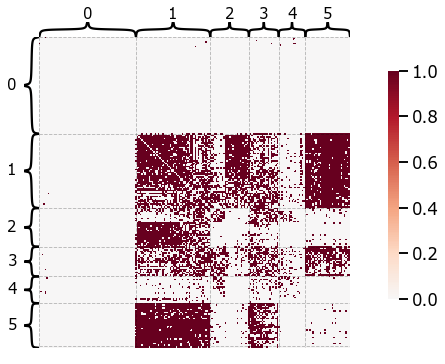

In [5]:
heatmap(left, inner_hier_labels=block_assignment, figsize=(8,6))

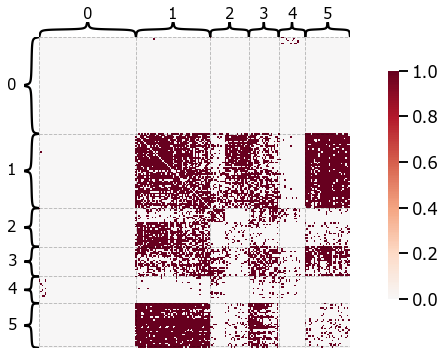

In [6]:
heatmap(right_rm, inner_hier_labels=block_assignment, figsize=(8,6))

In [7]:
def get_block_probabilities(A, vertex_labels):
    """
    Get the probabilities associated with edges given 
    the block membership of each vertex.
    Parameters
    ----------
    A : array_like
            Input adjacency matrix for which parameters are estimated.
    vertex_labels : array_like
            block membership of each vertex
    """
    K = len(np.unique(vertex_labels))
    idx = [(np.nonzero(vertex_labels == i)[0], i) for i in np.unique(vertex_labels)]
    P_hat = np.zeros((K, K))
    for i, j in idx:
        P_hat[j, j] = np.mean(A[i, i.min() : i.max()])
    for i, j in permutations(idx, 2):
        P_hat[i[1], j[1]] = np.mean(A[i[0], j[0].min() : j[0].max()])
    return P_hat

In [39]:
A = sort_graph(left, block_assignment)
vertex_labels = np.sort(block_assignment)

In [40]:
P_left = get_block_probabilities(A, vertex_labels)
P_left = np.nan_to_num(P_left)
P_left = symmetrize(P_left)

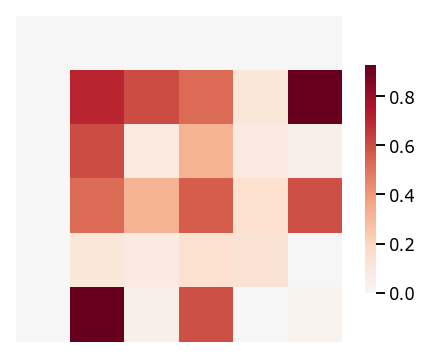

In [41]:
heatmap(P_left, figsize=(8,6))

In [42]:
_, num_in_blocks = np.unique(block_assignment, return_counts=True)
Ahat = sbm(n=num_in_blocks, p=P_left)

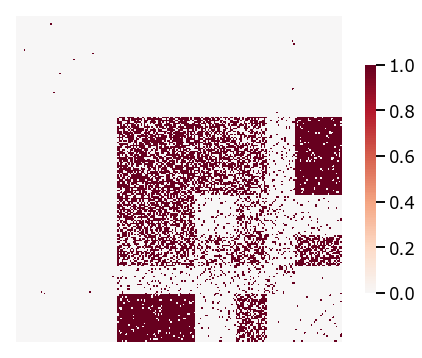

In [43]:
heatmap(Ahat, figsize=(8,6))

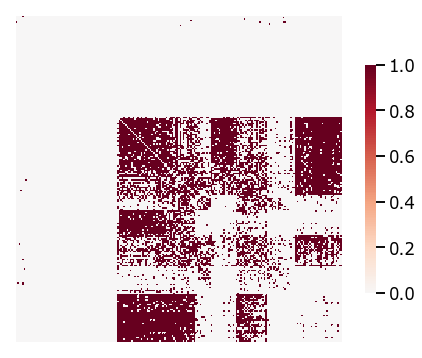

In [44]:
heatmap(A, figsize=(8,6))

In [45]:
np.linalg.norm(A-Ahat, ord='fro')

78.49840762716146

In [73]:
k_arr = np.linspace(1, 100, 100, dtype=int) #np.logspace(start=1, stop=6, num=6, base=2, dtype=int)
norm_arr = np.zeros_like(k_arr, dtype=float)
for i, k in tqdm(enumerate(k_arr)):
    block_assignment = estimate_block_assignment(left, right_rm, k=k, set_k=True, num_repeats=10)
    A = sort_graph(left, block_assignment)
    vertex_labels = np.sort(block_assignment)
    P_left = get_block_probabilities(A, vertex_labels)
    P_left = np.nan_to_num(P_left)
    P_left = symmetrize(P_left)
    _, num_in_blocks = np.unique(block_assignment, return_counts=True)
    Ahat = sbm(n=num_in_blocks, p=P_left)
    norm_arr[i] = np.linalg.norm(A-Ahat, ord='fro')

61it [00:33,  1.42it/s]

IndexError: index 61 is out of bounds for axis 0 with size 61

Text(0, 0.5, 'frobenius(A-Ahat)')

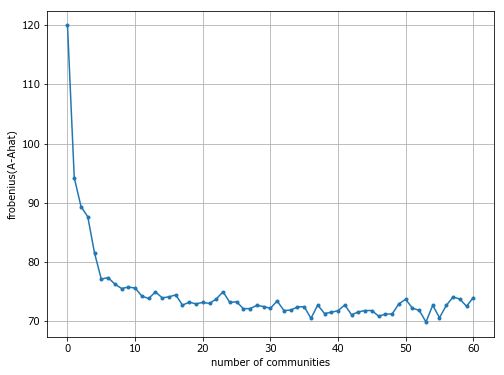

In [81]:
plt.figure(figsize=(8, 6))
plt.plot(norm_arr[np.where(norm_arr>0)], marker='.', linestyle='-')
plt.grid()
plt.xlabel('number of communities')
plt.ylabel('frobenius(A-Ahat)')